# 1. Imports

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 Librairies

In [4]:
!pip install plot_keras_history

In [5]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from plot_keras_history import show_history, plot_history
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## 1.2 Options

In [6]:
os.chdir("/content/drive/MyDrive/OpenClassrooms/Data Scientist/Projets/P6/Projet")

## 1.3 Data

In [7]:
df = pd.read_csv("Data/df_images.csv", sep=";")
df.head()

,uniq_id,product_name,image,category_level_1,category_level_2,category_level_3,category_level_4,category_level_5,category_level_6,category_level_7,filtered_text
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,Non spécifié,Non spécifié,Non spécifié,elegance polyester multicolor abstract eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",Non spécifié,Non spécifié,cotton bath towel bath towel red yellow blue b...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,Non spécifié,Non spécifié,eurospa cotton terry face towel set size small...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,Non spécifié,Non spécifié,santosh royal fashion cotton printed king size...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,Non spécifié,Non spécifié,jaipur print cotton floral king sized double b...


In [8]:
Image.MAX_IMAGE_PIXELS = None

def image_prep_fct(data):
    base_images_path = "Data/Images"

    prepared_images = []

    for image_name in df['image']:
        image_path = os.path.join(base_images_path, image_name)

        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)

    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(df)
X = images_np
print(X.shape)

(1050, 224, 224, 3)


In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['category_level_1'])
y = to_categorical(y_encoded)
y.shape

(1050, 7)

In [10]:
X_tmp, X_train, y_tmp, y_train = train_test_split(
    X,
    y,
    test_size=0.7,
    random_state=42,
    stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.5,
    random_state=42,
    stratify=y_tmp
)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(735, 224, 224, 3)
(157, 224, 224, 3)
(158, 224, 224, 3)


In [11]:
def create_model_fct():
    # Création d'une séquence d'augmentation de données pour générer des variations artificielles
    data_augmentation = Sequential([
        # Effectue des flips horizontaux aléatoires sur les images
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        # Applique une rotation aléatoire jusqu'à 10% sur les images
        RandomRotation(0.1),
        # Applique un zoom aléatoire jusqu'à 10% des images
        RandomZoom(0.1)
    ])

    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        # Gèle les poids du modèle pré-entrainé pour éviter des modifs durant le fit
        layer.trainable=False

    model = Sequential([
        data_augmentation,
        # Normalise les valeurs des pixels entre -1 et 1
        Rescaling(1./127.5, offset=-1),
        model_base,
        # Réduit chaque carte de carac en une seule valeur moyenne
        GlobalAveragePooling2D(),
        # Ajoute une couche dense avec 256 neurones et actiation de ReLU
        Dense(256, activation="relu"),
        # Applique une régularisation pour réduire le surajustement en désactivant 50% des neurones
        Dropout(0.5),
        # Ajoute une couche de sortie avec 7 classes et une activation softmax
        Dense(7, activation='softmax')
    ])


    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    print(model.summary())
    return model

In [12]:
with tf.device('/gpu:0'):
    model1 = create_model_fct()

model1_save_path1 = "./model1_best.weights.h5"
checkpoint_vgg16 = ModelCheckpoint(model1_save_path1, monitor="val_loss", save_weights_only=True,
                             verbose=1, save_best_only=True, mode="min")
early_stopping_vgg16 = EarlyStopping(monitor="val_loss", mode="min",
                               verbose=1, patience=5)
callbacks_list_vgg16 = [checkpoint_vgg16, early_stopping_vgg16]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [13]:
with tf.device('/gpu:0'):
    start_time_vgg16_aug = time.time()
    history_vgg16 = model1.fit(X_train, y_train, epochs=50, batch_size=64,
                        callbacks=callbacks_list_vgg16, validation_data=(X_val, y_val),
                        verbose=1)
    end_time_vgg16_aug = time.time()
    time_vgg16_aug = end_time_vgg16_aug - start_time_vgg16_aug
    print(f"Temps d'exécution : {time_vgg16_aug} secondes")

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.2523 - loss: 1.9803
Epoch 1: val_loss improved from inf to 1.37354, saving model to ./model1_best.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2556 - loss: 1.9702 - val_accuracy: 0.6369 - val_loss: 1.3735
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.4889 - loss: 1.4568
Epoch 2: val_loss improved from 1.37354 to 1.12094, saving model to ./model1_best.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 574ms/step - accuracy: 0.4920 - loss: 1.4518 - val_accuracy: 0.6561 - val_loss: 1.1209
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6272 - loss: 1.2113
Epoch 3: val_loss improved from 1.12094 to 0.95533, saving model to ./model1_best.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 380ms/step - accuracy: 0.6273 - loss: 1.2101 - val_accuracy: 0.7643 - val_loss: 0.9553
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6482 - loss: 1.1058
Epoch 4: val_loss improved from

In [14]:
train_loss_before_vgg16, train_accuracy_before_vgg16 = model1.evaluate(X_train, y_train, verbose=False)
val_loss_before_vgg16, val_accuracy_before_vgg16 = model1.evaluate(X_val, y_val, verbose=False)
test_loss_before_vgg16, test_accuracy_before_vgg16 = model1.evaluate(X_test, y_test, verbose=False)

model1.load_weights(model1_save_path1)

train_loss_after_vgg16, train_accuracy_after_vgg16 = model1.evaluate(X_train, y_train, verbose=False)
val_loss_after_vgg16, val_accuracy_after_vgg16 = model1.evaluate(X_val, y_val, verbose=False)
test_loss_after_vgg16, test_accuracy_after_vgg16 = model1.evaluate(X_test, y_test, verbose=False)

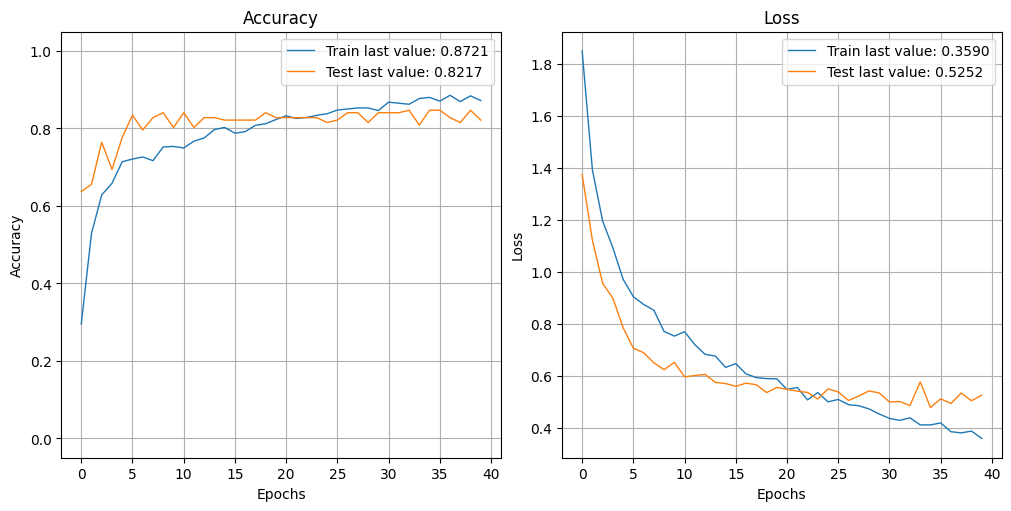

In [15]:
show_history(history_vgg16)
plot_history(history_vgg16)
plt.close()

In [16]:
def create_mobilenetv2_model():
  data_augmentation = Sequential([
      RandomFlip("horizontal", input_shape=(224, 224, 3)),
      RandomRotation(0.1),
      RandomZoom(0.1)
  ])

  model_base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
  for layer in model_base.layers:
      layer.trainable=False

  model = Sequential([
      data_augmentation,
      Rescaling(1./127.5, offset=-1),
      model_base,
      GlobalAveragePooling2D(),
      Dense(256, activation="relu"),
      Dropout(0.5),
      Dense(7, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  print(model.summary())
  return model

In [17]:
with tf.device('/gpu:0'):
    model2 = create_mobilenetv2_model()

model2_save_path1 = "./model2_best.weights.h5"
checkpoint_mobilenet = ModelCheckpoint(model2_save_path1, monitor="val_loss", save_weights_only=True,
                             verbose=1, save_best_only=True, mode="min")
early_stopping_mobilenet = EarlyStopping(monitor="val_loss", mode="min",
                               verbose=1, patience=5)
callbacks_list_mobilenet = [checkpoint_mobilenet, early_stopping_mobilenet]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [18]:
with tf.device('/gpu:0'):
    start_time_mobilenet_aug = time.time()
    history_mobilenet = model2.fit(X_train, y_train, epochs=50, batch_size=64,
                        callbacks=callbacks_list_mobilenet, validation_data=(X_val, y_val),
                        verbose=1)
    end_time_mobilenet_aug = time.time()
    time_mobilenet_aug = end_time_mobilenet_aug - start_time_mobilenet_aug
    print(f"Temps d'exécution : {time_mobilenet_aug} secondes")

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2681 - loss: 2.7057
Epoch 1: val_loss improved from inf to 0.79052, saving model to ./model2_best.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 620ms/step - accuracy: 0.2778 - loss: 2.6561 - val_accuracy: 0.7898 - val_loss: 0.7905
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6414 - loss: 1.0448
Epoch 2: val_loss improved from 0.79052 to 0.68405, saving model to ./model2_best.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.6441 - loss: 1.0401 - val_accuracy: 0.7898 - val_loss: 0.6841
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7570 - loss: 0.7563
Epoch 3: val_loss improved from 0.68405 to 0.60701, saving model to ./model2_best.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.7565 - loss: 0.7561 - val_accuracy: 0.8217 - val_loss: 0.6070
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7631 - loss: 0.6912
Epoch 4: val_loss improved fr

In [19]:
train_loss_before_mobilenet, train_accuracy_before_mobilenet = model2.evaluate(X_train, y_train, verbose=False)
val_loss_before_mobilenet, val_accuracy_before_mobilenet = model2.evaluate(X_val, y_val, verbose=False)
test_loss_before_mobilenet, test_accuracy_before_mobilenet = model2.evaluate(X_test, y_test, verbose=False)

model2.load_weights(model2_save_path1)

train_loss_after_mobilenet, train_accuracy_after_mobilenet = model2.evaluate(X_train, y_train, verbose=False)
val_loss_after_mobilenet, val_accuracy_after_mobilenet = model2.evaluate(X_val, y_val, verbose=False)
test_loss_after_mobilenet, test_accuracy_after_mobilenet = model2.evaluate(X_test, y_test, verbose=False)

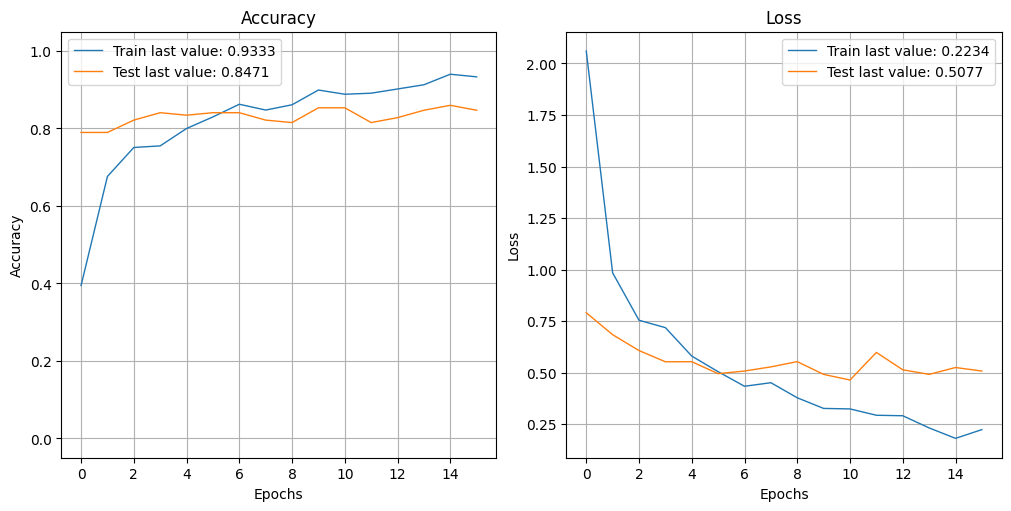

In [20]:
show_history(history_mobilenet)
plot_history(history_mobilenet)
plt.close()

In [21]:
def create_vgg16_no_augmentation():
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        # Gèle les poids du modèle pré-entrainé pour éviter des modifs durant le fit
        layer.trainable=False

    model = Sequential([
        # Normalise les valeurs des pixels entre -1 et 1
        Rescaling(1./127.5, offset=-1),
        model_base,
        # Réduit chaque carte de carac en une seule valeur moyenne
        GlobalAveragePooling2D(),
        # Ajoute une couche dense avec 256 neurones et actiation de ReLU
        Dense(256, activation="relu"),
        # Applique une régularisation pour réduire le surajustement en désactivant 50% des neurones
        Dropout(0.5),
        # Ajoute une couche de sortie avec 7 classes et une activation softmax
        Dense(7, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    print(model.summary())
    return model

In [22]:
with tf.device('gpu:0'):
  model_vgg16_no_aug = create_vgg16_no_augmentation()

vgg16_no_aug_path = "./model3_best.weights.h5"
checkpoint_vgg16_no_aug = ModelCheckpoint(vgg16_no_aug_path, monitor="val_loss", save_weights_only=True,
                             verbose=1, save_best_only=True, mode="min")
early_stopping_vgg16_no_aug = EarlyStopping(monitor="val_loss", mode="min",
                               verbose=1, patience=5)
callbacks_list_vgg16_no_aug = [checkpoint_vgg16_no_aug, early_stopping_vgg16_no_aug]

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [23]:
with tf.device('/gpu:0'):
    start_time_vgg16_no_aug = time.time()
    history_vgg16_no_aug = model_vgg16_no_aug.fit(X_train, y_train, epochs=50, batch_size=64,
                        callbacks=callbacks_list_vgg16_no_aug, validation_data=(X_val, y_val),
                        verbose=1)
    end_time_vgg16_no_aug = time.time()
    time_vgg16_no_aug = end_time_vgg16_no_aug - start_time_vgg16_no_aug
    print(f"Temps d'exécution : {time_vgg16_no_aug} secondes")

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2820 - loss: 1.8391   
Epoch 1: val_loss improved from inf to 1.22880, saving model to ./model3_best.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.2891 - loss: 1.8248 - val_accuracy: 0.7197 - val_loss: 1.2288
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5905 - loss: 1.2544
Epoch 2: val_loss improved from 1.22880 to 0.98844, saving model to ./model3_best.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 528ms/step - accuracy: 0.5929 - loss: 1.2490 - val_accuracy: 0.7452 - val_loss: 0.9884
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6621 - loss: 1.0461
Epoch 3: val_loss improved from 0.98844 to 0.87487, saving model to ./model3_best.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - accuracy: 0.6647 - loss: 1.0416 - val_accuracy: 0.7134 - val_loss: 0.8749
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7392 - loss: 0.8659
Epoch 4: val_loss improved from

In [24]:
model_vgg16_no_aug.load_weights(vgg16_no_aug_path)

train_loss_vgg16_no_aug, train_accuracy_vgg16_no_aug = model_vgg16_no_aug.evaluate(X_train, y_train, verbose=False)
val_loss_vgg16_no_aug, val_accuracy_vgg16_no_aug = model_vgg16_no_aug.evaluate(X_val, y_val, verbose=False)
test_loss_vgg16_no_aug, test_accuracy_vgg16_no_aug = model_vgg16_no_aug.evaluate(X_test, y_test, verbose=False)

In [25]:
def create_mobilenetv2_no_augmentation():
    model_base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        # Gèle les poids du modèle pré-entrainé pour éviter des modifs durant le fit
        layer.trainable=False

    model = Sequential([
        # Normalise les valeurs des pixels entre -1 et 1
        Rescaling(1./127.5, offset=-1),
        model_base,
        # Réduit chaque carte de carac en une seule valeur moyenne
        GlobalAveragePooling2D(),
        # Ajoute une couche dense avec 256 neurones et actiation de ReLU
        Dense(256, activation="relu"),
        # Applique une régularisation pour réduire le surajustement en désactivant 50% des neurones
        Dropout(0.5),
        # Ajoute une couche de sortie avec 7 classes et une activation softmax
        Dense(7, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    print(model.summary())
    return model

In [26]:
with tf.device('gpu:0'):
  model_mobilenet_no_aug = create_mobilenetv2_no_augmentation()

mobilenet_no_aug_path = "./model4_best.weights.h5"
checkpoint_mobilenet_no_aug = ModelCheckpoint(mobilenet_no_aug_path, monitor="val_loss", save_weights_only=True,
                             verbose=1, save_best_only=True, mode="min")
early_stopping_mobilenet_no_aug = EarlyStopping(monitor="val_loss", mode="min",
                               verbose=1, patience=5)
callbacks_list_mobilenet_no_aug = [checkpoint_mobilenet_no_aug, early_stopping_mobilenet_no_aug]

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [27]:
with tf.device('/gpu:0'):
    start_time_mobilenet_no_aug = time.time()
    history_mobilenet_no_aug = model_mobilenet_no_aug.fit(X_train, y_train, epochs=50, batch_size=64,
                        callbacks=callbacks_list_mobilenet_no_aug, validation_data=(X_val, y_val),
                        verbose=1)
    end_time_mobilenet_no_aug = time.time()
    time_mobilenet_no_aug = end_time_mobilenet_no_aug - start_time_mobilenet_no_aug
    print(f"Temps d'exécution : {time_mobilenet_no_aug} secondes")

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.4453 - loss: 1.6679
Epoch 1: val_loss improved from inf to 0.58057, saving model to ./model4_best.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4549 - loss: 1.6406 - val_accuracy: 0.7898 - val_loss: 0.5806
Epoch 2/50
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7818 - loss: 0.6528
Epoch 2: val_loss did not improve from 0.58057
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7829 - loss: 0.6495 - val_accuracy: 0.7898 - val_loss: 0.6319
Epoch 3/50
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8703 - loss: 0.4117
Epoch 3: val_loss improved from 0.58057 to 0.54178, saving model to ./model4_best.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.8689 - loss: 0.4138 - val_accuracy: 0.8089 - val_loss: 0.5418
Epoch 4/50
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8863 - loss: 0.3485
Epoch 4: val_loss improved from 0.54178 to 0.52277, saving model to ./model4_best.

In [28]:
model_mobilenet_no_aug.load_weights(mobilenet_no_aug_path)

train_loss_mobilenet_no_aug, train_accuracy_mobilenet_no_aug = model_mobilenet_no_aug.evaluate(X_train, y_train, verbose=False)
val_loss_mobilenet_no_aug, val_accuracy_mobilenet_no_aug = model_mobilenet_no_aug.evaluate(X_val, y_val, verbose=False)
test_loss_mobilenet_no_aug, test_accuracy_mobilenet_no_aug = model_mobilenet_no_aug.evaluate(X_test, y_test, verbose=False)

In [30]:
results_df = pd.DataFrame({
    'Model': [
        'VGG16 (data augmentation)',
        'VGG16 (sans data augmentation)',
        'MobileNetV2 (data augmentation)',
        'MobileNetV2 (sans data augmentation)'
        ],

    'Train Accuracy': [
        train_accuracy_after_vgg16, train_accuracy_vgg16_no_aug,
        train_accuracy_after_mobilenet, train_accuracy_mobilenet_no_aug],

    'Validation Accuracy': [
        val_accuracy_after_vgg16, val_accuracy_vgg16_no_aug,
        val_accuracy_after_mobilenet, val_accuracy_mobilenet_no_aug],

    'Test Accuracy': [
        test_accuracy_after_vgg16, test_accuracy_vgg16_no_aug,
        test_accuracy_after_mobilenet, test_accuracy_mobilenet_no_aug],

    'Train Loss': [
        train_loss_after_vgg16, train_loss_vgg16_no_aug,
        train_loss_after_mobilenet, train_loss_mobilenet_no_aug],

    'Validation Loss': [
        val_loss_after_vgg16, val_loss_vgg16_no_aug,
        val_loss_after_mobilenet, val_loss_mobilenet_no_aug],

    'Test Loss' : [
        test_loss_after_vgg16, test_loss_vgg16_no_aug,
        test_loss_after_mobilenet, test_loss_mobilenet_no_aug],

    'Temps d\'exécution (s)' : [
        time_vgg16_aug, time_vgg16_no_aug,
        time_mobilenet_aug, time_mobilenet_no_aug],

    'Epochs utilisées' : [
        len(history_vgg16.epoch), len(history_vgg16_no_aug.epoch),
        len(history_mobilenet.epoch), len(history_mobilenet_no_aug.epoch)
    ]
})

results_df.style.format({
    'Train Accuracy': '{:.2%}',
    'Validation Accuracy': '{:.2%}',
    'Test Accuracy': '{:.2%}',
    'Train Loss': '{:.4f}',
    'Validation Loss': '{:.4f}',
    'Test Loss': '{:.4f}',
    'Temps d\'exécution (s)' : '{:.2f}'
}).set_caption('Résultats des modèles avec et sans data augmentation')

,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Train Loss,Validation Loss,Test Loss,Temps d'exécution (s),Epochs utilisées
0,VGG16 (data augmentation),91.84%,84.71%,80.38%,0.2702,0.4774,0.7354,303.66,40
1,VGG16 (sans data augmentation),93.74%,85.35%,79.11%,0.2506,0.4838,0.6934,223.06,28
2,MobileNetV2 (data augmentation),95.51%,85.35%,78.48%,0.1626,0.4642,0.6384,47.31,16
3,MobileNetV2 (sans data augmentation),97.28%,84.08%,74.68%,0.1099,0.5031,0.6796,45.94,11


Voici la conclusion de ces différents modèles avec et sans data augmentation.

**VGG16**
- Train Accuracy
  - Sans augmentation, il possède une meilleure précision.
- Validation Accuracy
  - On obtient des résultats similaires. La data augmentation n'a pas vraiment d'effets avec nos paramètres actuels.
- Test Accuracy
 - Le modèle sans augmentation est légèrement meilleur. Les résultats de la data augmentation sont similaires à la **Validation Accuracy**

Concernant les loss, le modèle apprend mieux sans data augmentation.

**MobileNetV2**
- Train Accuracy
  - Légère augmentation sans data augmentation.
- Validation Accuracy
  - Meilleure score en terme de validation avec data augmentation, contrairement au modèle **VGG16**
- Test Accuracy
  - Résultats similaire à la **Validation Accuracy**

Concernant les loss, on a une meilleure perte avec la data augmentation.

Dans la globalité, le modèle MobileNetV2 gère mieux la data augmentation car cela apporte de meilleurs résultats, contrairement à VGG16, en tout cas avec nos paramètres actuels.

On remarque également un meilleur temps d'exécution pour les modèles MobileNetV2 avec un nombre d'epochs moins grand.

In [31]:
y_pred_prob = model1.predict(X_test)

y_pred_classes = np.argmax(y_pred_prob, axis=1)

y_true_classes = np.argmax(y_test, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


In [33]:
error_indices = np.where(y_pred_classes != y_true_classes)[0]
print(len(error_indices))

31


In [34]:
errors_df = pd.DataFrame({
    'Index' : error_indices,
    'Vraie catégorie' : y_true_classes[error_indices],
    'Prédiction' : y_pred_classes[error_indices]
})

errors_df.head()

,Index,Vraie catégorie,Prédiction
0,4,2,5
1,8,0,4
2,15,2,6
3,16,1,5
4,25,5,1


In [36]:
sampled_error = errors_df.sample(5)

In [43]:
category_names = label_encoder.classes_

sampled_error['Vraie catégorie'] = sampled_error['Vraie catégorie'].apply(lambda x: category_names[x])
sampled_error['Prédiction'] = sampled_error['Prédiction'].apply(lambda x: category_names[x])

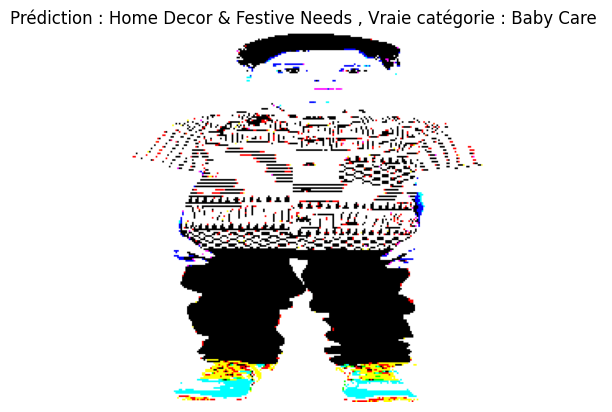

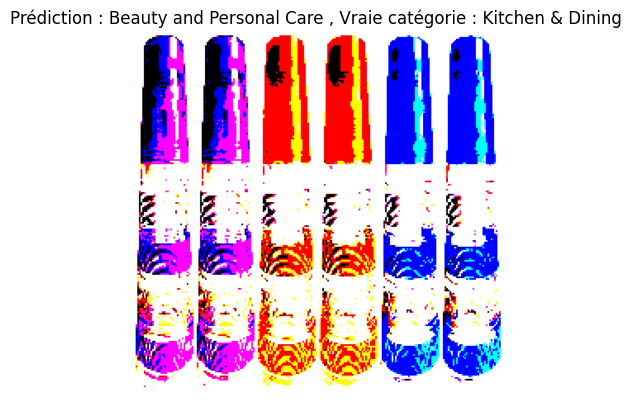

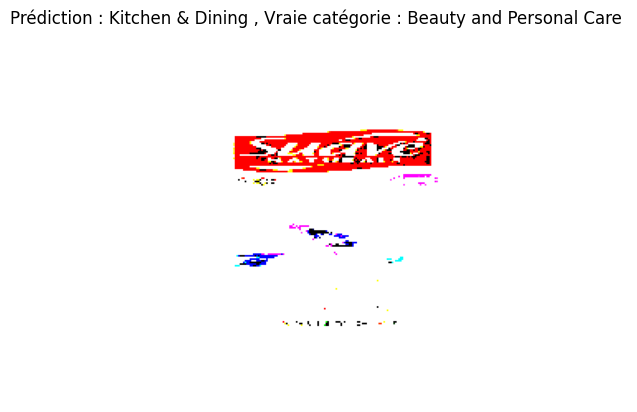

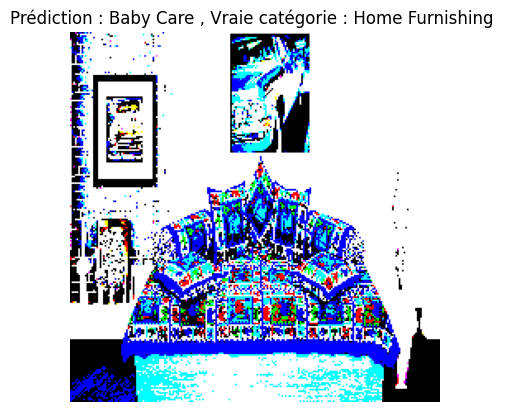

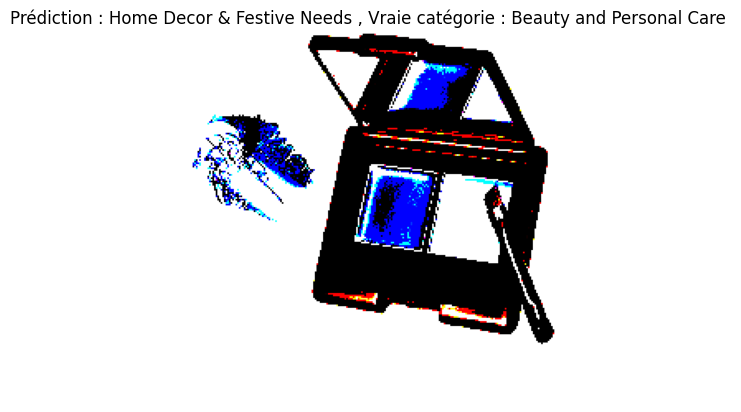

In [49]:
for i, row in sampled_error.iterrows():
    plt.imshow(X_test[row['Index']])
    plt.title(f"Prédiction : {row['Prédiction']}, Vraie catégorie : {row['Vraie catégorie']}")
    plt.axis('off')
    plt.show()